In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.cm import get_cmap
import numpy as np

In [2]:
directions = np.array([[1,0], [0,1], [-1,0], [0,-1], [1,1], [-1,1], [-1,-1], [1,-1]])
arena_x = 25
arena_y = 25
p_unlocking = 0.0

In [3]:
class Agent():
    def __init__(self, x, y, index=None):
        self.x = x
        self.y = y
        self.index = index
        self.locked = False
        
    def move(self):  # move in a random direction
        #theta = 2*np.pi*np.random.random()
        ind = np.random.randint(directions.shape[0])
        v = directions[ind].copy()
        self.x = (self.x + v[0]) % arena_x
        self.y = (self.y + v[1]) % arena_y

In [16]:
class Simulation():
    def __init__(self, population_size):
        self.population = [ 
            Agent(np.random.randint(arena_x), np.random.randint(arena_y), index=i) for i in range(population_size) ]
        
        self.arena_active = np.array([[0 for _ in range(arena_x)] for _ in range(arena_y)])
        self.arena_locked = self.arena_active.copy()
        self.arena = None
        self.history = None
        
        self.setup()
        
    def setup(self):  # place agents into arena
        for agent in self.population:  
            x = agent.x
            y = agent.y

            # code below assumes no agent is locked
            if self.arena_active[y][x] >= 1: # may be strange but the agent is placed underneath others
                agent.locked = True
                self.arena_locked[y][x] += 1
            else:
                self.arena_active[y][x] += 1
                
        self.arena = self.arena_active + self.arena_locked
        #self.history = self.arena.copy()
        self.history = np.expand_dims(self.arena.copy(), axis=2)
        
                
    def move_agents(self):  # movement logic
        for agent in self.population: 
            if not agent.locked:  # locked agents won't move
                x_0, y_0 = agent.x, agent.y
                x, y = agent.x, agent.y 
                
                br = 0
                while self.arena_active[y][x] >= 1: #check for collisions
                    agent.x, agent.y = x_0, y_0
                    agent.move()
                    x, y = agent.x, agent.y
                    
                    br +=1
                    if br >= 10: # shouldn't trigger but just in case
                        agent.x, agent.y = x_0, y_0
                        x, y = x_0, y_0
                        break
                
                self.arena_active[y_0][x_0] -= 1
                self.arena_active[y][x] += 1
                
                    
    def update_states(self):
        for agent in self.population: # locking/unlocking logic
            x, y = agent.x, agent.y

            if not agent.locked:
                locked_neighbors = 0

                for i in range(3): # count how many locked neighbors there are
                    for j in range(3):
                        y_ = (y + i - 1) % 10
                        x_ = (x + j - 1) % 10
                        locked_neighbors += self.arena_locked[y_][x_]

                alpha = locked_neighbors/8.0
                r = np.random.random()

                if r < alpha or r < 0.01:  # agent more likely to become locked with more locked neighbors + flat base chance of locking
                    agent.locked = True
                    self.arena_active[y][x] -= 1
                    self.arena_locked[y][x] += 1
                    continue

            elif agent.locked and self.arena_active[y][x] == 0: # uncovered locked agents can randomly unlock
                r = np.random.random()
                if r < p_unlocking:
                    agent.locked = False
                    self.arena_locked[y][x] -= 1
                    self.arena_active[y][x] += 1
                    
    def show_arena(self):
        plt.imshow(self.arena)
        
    def step(self, n):
        for _ in range(n):
            sim.move_agents()
            sim.update_states()
            
            self.arena = self.arena = self.arena_active + self.arena_locked
            self.history = np.append(self.history, np.expand_dims(self.arena, axis=2), axis=2)
            
        self.show_arena()
        
    def animate_frame(self, i):
        frame = plt.imshow(self.history[:, :, i], vmax=self.max)
        return frame
        
    def animate_history(self):
        self.max = np.max(self.history)
        
        Writer = animation.writers["ffmpeg"]
        writer = Writer(fps=14, bitrate=1800)
        
        fig = plt.figure(figsize=(10,6))
        
        ani = animation.FuncAnimation(fig, self.animate_frame, frames=20)
        ani.save("Automata_1.mp4", writer=writer)
        

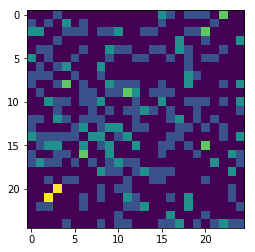

In [20]:
sim = Simulation(300)

sim.show_arena()

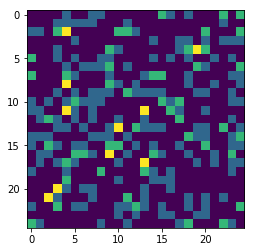

In [21]:
sim.step(30)

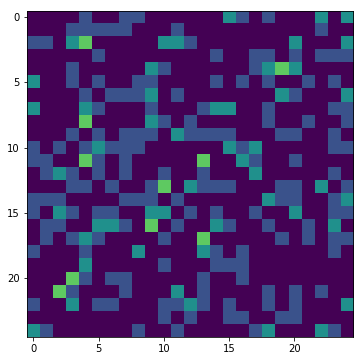

In [22]:
sim.animate_history()